In [1]:
!pip install pyyaml
!pip install dndice
!pip install python-i18n
!pip install gymnasium
!pip install inflect
!pip install collections-extended
!pip install openai
!pip install -e ..
!pip install ipywidgets
!pip install iprogress


Obtaining file:///home/jedld/workspace/natural_20.py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: natural20.py
    Found existing installation: natural20.py 0.1
    Uninstalling natural20.py-0.1:
      Successfully uninstalled natural20.py-0.1
  Running setup.py develop for natural20.py


In [2]:
from gymnasium import make
from model import QNetwork
from natural20.gym.dndenv import dndenv
import torch
import tqdm as tqdm
import tqdm.notebook as tqdm
import random
import torch.optim as optim
import torch.nn as nn
import gc
import numpy as np
import sys
import collections
from natural20.session import Session
from natural20.event_manager import EventManager
from natural20.gym.dqn.replay_buffer import ReplayBuffer
import os
from llm_interface import GPT4Interfacer

In [3]:
if torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [4]:
env_config = "map_with_obstacles"
PROJECT_OUTPUT_PATH = "model_weights_all"
if not os.path.exists(PROJECT_OUTPUT_PATH):
  os.mkdir(PROJECT_OUTPUT_PATH)

In [5]:
session = Session(env_config, event_manager=EventManager())

Show info about the environment and a render of the tabletop map

In [6]:
env = make("dndenv-v0", root_path="map_with_obstacles", show_logs=True,
           custom_session=session,
           damaged_based_reward=True,
           render_mode="ansi")
env.reset()
print(env.render())
print(env.observation_space)
print(env.action_space.sample)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 11/18 AC 16===
____________
____________
___... ...__
___... ...__
___..E#...__
___.~~~~..__
___~~~P...__
___~~.....__
____________
____________
____________
____________
Dict('ability_info': Box(0, 1, (8,), int64), 'conditions': Box(0, 1, (8,), int64), 'enemy_ac': Box(0.0, 1.0, (1,), float64), 'enemy_conditions': Box(0, 1, (8,), int64), 'enemy_reactions': Box(0, 1, (1,), int64), 'enemy_type': Box(0, 1, (1,), int64), 'health_enemy': Box(0.0, 1.0, (1,), float64), 'health_pct': Box(0.0, 1.0, (1,), float64), 'is_reaction': Box(0

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


DQN Parameters

In [7]:
TRAJECTORY_POLICY = "e-greedy"
NUM_UPDATES = 2 # number of training steps to update the Q-network
TEMP_DECAY = 0.999
BUFFER_CAPACITY = 3000
FRAMES_TO_STORE = 2
MAX_STEPS = 3000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 1 # how often to update the target network
T_HORIZON = 512
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY_FRAMES = 10**3
EVAL_STEPS = 30

In [8]:
model = QNetwork(device=device)
model.to(device)
state, info = env.reset()
moves = info["available_moves"]
model.eval()
print(model(state, moves[0]))

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
tensor([[0.0573]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
def act_with_policy(state, info, model, policy='e-greedy', temperature=5.0, epsilon=0.1):
    available_moves = info["available_moves"]
    with torch.no_grad():
        if policy == 'boltzmann':
            values = torch.stack([model(state, move).squeeze() for move in available_moves])
            if len(values) > 1:
                if temperature != 0:
                    values = values / temperature
                else:
                    raise ValueError("Temperature is zero, which can lead to division by zero.")

                # Stabilizing the exponential calculation
                values = values - torch.max(values)  # Subtract the max value for numerical stability
                values = torch.exp(values)
                sum_values = torch.sum(values)

                if sum_values > 0:
                    values = values / sum_values
                    chosen_index = torch.multinomial(values, 1).item()
                else:
                    print("Sum of exponentiated values is zero. Adjust the model or input.")
                    chosen_index = torch.randint(len(available_moves), (1,)).item()
            else:
                chosen_index = 0
        elif policy == 'e-greedy':
            if random.random() < epsilon:
                # place available moves in buckets according to their type
                # this is so that movements are not chosen more often than other types of moves
                move_types = collections.defaultdict(list)
                for orig_index, move in enumerate(available_moves):
                    move_types[move[0]].append(orig_index)
                chosen_move_type = random.choice(list(move_types.keys()))
                chosen_index = random.choice(move_types[chosen_move_type])
            else:
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        elif policy == 'greedy':
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    return available_moves[chosen_index]

def generate_trajectory(env, model, policy='e-greedy', temperature=5.0, epsilon=0.1, horizon=500, quick_exit=False):

    done = False
    truncated = False
    states = []
    actions = []
    rewards = []
    dones = []
    truncateds = []
    infos = []
    truncated = False


    def reaction_callback(state, reward, done, truncated, info):
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        return action

    state, info = env.reset(reaction_callback=reaction_callback)

    for _ in range(horizon):
        # instead of sampling  (e.g. env.action_space.sample()) we can ask help from the enivronment to obtain valid moves
        # as there are sparse valid moves in the environment
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        next_state, reward, done, truncated, next_info = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        if done:
            break    
        if truncated:
            truncated = True
            break
        state = next_state
        info = next_info
        
    states.append(next_state)
    infos.append(next_info)
    actions.append((-1, (0,0), (0,0), 0, 0))
    return states, actions, rewards, dones, truncateds, infos

In [10]:
trajectory = generate_trajectory(env, model, epsilon=1.0)
print(trajectory)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 9/18 AC 16===
Result: False
==== end turn ===
gomerin 9/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gome

In [11]:
EPISODES = 10
total_rewards = 0
for i in tqdm.tqdm(range(EPISODES)):
    states, actions, rewards, dones, truncateds, infos = generate_trajectory(env, model, epsilon=1.0)
    total_rewards += sum(rewards)

avg_reward = total_rewards/EPISODES
print(f"Average reward: {avg_reward} Total Reward: {total_rewards}")

  0%|          | 0/10 [00:00<?, ?it/s]

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
Result: False
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
Result: False
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
Result: False
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== curr

In [12]:
# generate a batch of trajectories and store them in the replay buffer
def generate_batch_trajectories(env, model, n_rollout, replay_buffer: ReplayBuffer, temperature=5.0, epsilon=0.1, horizon=30, policy='e-greedy'):
    # print(f"generating {n_rollout} rollouts")
    for _ in range(n_rollout):
        state, action, reward, done, truncated, info = generate_trajectory(env, model, temperature=temperature,
                                                                           epsilon=epsilon,
                                                                           horizon=horizon,policy=policy)
        replay_buffer.push(state, action, reward, info, done)

In [13]:
def train(env, gamma, learning_rate, max_steps=MAX_STEPS, use_td_target=True,
          trajectory_policy='e-greedy',
          label="dnd_egreedy",
          eval_env=None,
          reward_per_episode=None,
          n_rollout=8,
          seed=1337):
  print(f"training with gamma {gamma} and learning rate {learning_rate}")
  env.seed(seed)

  replay_buffer = ReplayBuffer(BUFFER_CAPACITY, device)
  # load model checkpoint if available
  model = QNetwork(device).to(device)
  target_model = QNetwork(device).to(device)

  # intialize target network with the same weights as the model
  target_model.load_state_dict(model.state_dict())

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_avg = -10
  best_step = 0
  temperature = 5.0
  if reward_per_episode is None:
    reward_per_episode = []
    
  epsilon = EPSILON_START

  for step in tqdm.tqdm(range(max_steps)):
    generate_batch_trajectories(env, model, n_rollout, replay_buffer, temperature=temperature,
                                epsilon=epsilon, policy=trajectory_policy, horizon=T_HORIZON)

    states, actions, rewards, infos, is_terminals = replay_buffer.sample(BATCH_SIZE)
    rewards_collected = 0
    for _ in range(NUM_UPDATES):
      rewards_collected = 0
      total_loss = 0.0

      for i in range(len(states)):
        s = states[i]
        a = actions[i]
        env_info = infos[i]
        r = torch.tensor(rewards[i]).to(device).unsqueeze(1)
        is_terminal = torch.tensor(is_terminals[i]).float().to(device).unsqueeze(1)

        if use_td_target:
          with torch.no_grad():
            s_next = s[1:]
            a_next = a[1:]
            q_targets = target_model.forward(s_next, a_next, pre_converted=True, pre_converted_action=True).detach()
        else: # Q-learning target == "slow"
          with torch.no_grad():
            s_next = s[1:]
            s_info = env_info[1:]
            q_targets = torch.zeros(len(s_next)).to(device)

            for index in range(len(s_info)):
              info = s_info[index]
              state = s_next[index]

              if len(state) == 0:
                q_targets[index] = 0
                continue

              total_available_moves = len(info["available_moves"])
              states_t = [state] * total_available_moves
              avail_actions = info["available_moves"]
              assert len(states_t) > 0, "No available states"
              assert len(avail_actions) > 0, "No available moves"

              q_values = target_model.forward(states_t, avail_actions, pre_converted=True).detach().squeeze(1)
              if len(q_values) == 0:
                q_targets[index] = 0
              else:
                q_targets[index] = torch.max(q_values).item()

            q_targets = q_targets.unsqueeze(1)
            assert q_targets.shape == r.shape, f"q_targets shape {q_targets.shape} != r shape {r.shape}"

        targets = r + gamma * q_targets * (1 - is_terminal)

        s_input = s[0:-1]
        a_input = a[0:-1]
        output = model.forward(s_input, a_input, pre_converted=True, pre_converted_action=True)
        q_sa = output

        value_loss = nn.MSELoss()(q_sa, targets)
        optimizer.zero_grad()
        value_loss.backward()
        total_loss += value_loss.item()
        rewards_collected += r.sum().item()
        optimizer.step()

    # save model checkpoint

    # evaluate model performance
    if step % 10 == 0:
      if eval_env is None:
        eval_env = env

      eval_rewards = []
      for _ in range(EVAL_STEPS):
        _, _, rewards, _, _, _ = generate_trajectory(eval_env, model, policy='greedy')
        total_reward = sum(rewards)
        eval_rewards.append(total_reward)

      avg_rewards = np.mean(eval_rewards)
     
      # print(f"eval rewards: {avg_rewards}")
      reward_per_episode.append(avg_rewards)
      std_rewards = np.std(reward_per_episode)

      # print(f"total reward: {total_reward}")
      if trajectory_policy == "e-greedy":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} epsilon {epsilon}")
      elif trajectory_policy == "boltzmann":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} temperature {temperature}")
      else:
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step}")

      replay_buffer.print_stats()

      if avg_rewards > best_avg:
        print(f"best: {avg_rewards}")
        best_avg = avg_rewards
        best_step = step
        torch.save(model.state_dict(), f"{PROJECT_OUTPUT_PATH}/model_best_{label}@{step}.pt")
        torch.save(model.state_dict(), f"{PROJECT_OUTPUT_PATH}/model_best_{label}.pt")

      # torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}.pt")


    # if step % 100 == 0:
    #   torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}_{step}.pt")


    gc.collect()
    
    # decay temp
    temperature = np.max([0.1, temperature * TEMP_DECAY])

    # decay epsilon
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1.0 * step / EPSILON_DECAY_FRAMES)

    if step % TARGET_UPDATE_FREQ == 0:
      # calculate the avg change weights of the model with the target model
      total_change = 0
      for p, p_target in zip(model.parameters(), target_model.parameters()):
        total_change += torch.abs(p - p_target).sum().item()
      # print(f"total change: {total_change}")

      target_model.load_state_dict(model.state_dict())

  env.close()
  return reward_per_episode


Specify the location of the game configuration

In [16]:
game_setup_path = "map_with_obstacles"

Create the env setup. Note that we use damaged based rewards to give a denser reward signalling.

In [17]:
def make_env(root_path, render_mode="ansi", show_logs=False, custom_agent=None):
    return make("dndenv-v0", root_path=root_path, show_logs=show_logs,
                render_mode=render_mode,
                damage_based_reward=True,
                custom_agent=custom_agent,
                profiles=lambda: random.choice(['high_elf_fighter', 'high_elf_mage', 'dwarf_cleric', 'halfling_rogue']),
                enemies=lambda: random.choice(['high_elf_fighter', 'high_elf_mage', 'dwarf_cleric', 'halfling_rogue']),
                map_file=lambda: random.choice(['maps/simple_map',\
                                                'maps/complex_map', \
                                                'maps/game_map', \
                                                'maps/walled_map'])
                )

In [18]:
env = make_env(game_setup_path)

In [19]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.0001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, use_td_target=True)
    results[lr][gamma] = reward_per_episode


training with gamma 0.99 and learning rate 0.0001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


0: avg rewards -2.3888888888888884 std: 0.0 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 255616 bytes
best: -2.3888888888888884
10: avg rewards 1.611111111111111 std: 1.9999999999999996 best avg -2.3888888888888884@0 epsilon 0.9911299749851548
Buffer size: 88
Memory usage: 2270400 bytes
best: 1.611111111111111
20: avg rewards 4.581018518518518 std: 2.8557925398585553 best avg 1.611111111111111@10 epsilon 0.9813675686203779
Buffer size: 168
Memory usage: 4107392 bytes
best: 4.581018518518518
30: avg rewards -1.6689814814814816 std: 2.780959067565842 best avg 4.581018518518518@20 epsilon 0.9717022998219388
Buffer size: 248
Memory usage: 5658048 bytes
40: avg rewards -0.8716931216931215 std: 2.5500875763942523 best avg 4.581018518518518@20 epsilon 0.962133202054903
Buffer size: 328
Memory usage: 8309760 bytes
50: avg rewards -3.4302248677248675 std: 2.7023713804782177 best avg 4.581018518518518@20 epsilon 0.9526593184015199
Buffer size: 408
Memory usage: 10225536 bytes
60: avg 

Summarize rewards per episode

In [20]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.0001 gamma: 0.99 rewards: [-2.3888888888888884, 1.611111111111111, 4.581018518518518, -1.6689814814814816, -0.8716931216931215, -3.4302248677248675, 3.0029761904761907, 0.5023148148148149, 1.4236111111111112, -0.00925925925925976, 0.6772486772486773, 0.5142195767195769, 0.8237433862433863, 2.0347222222222223, 5.358134920634921, 1.4923941798941796, -0.6597222222222224, 0.09259259259259271, 3.323743386243386, 1.6296296296296295, 1.9656084656084656, 1.25462962962963, 2.0833333333333335, -1.3915343915343916, 2.7013888888888897, 4.180555555555555, 0.611441798941799, 3.111111111111111, 2.1574074074074074, 2.055555555555556, 1.9593253968253965, 3.462962962962963, 1.4351851851851856, 0.7695105820105819, 4.127314814814815, 0.7546296296296298, 4.256944444444445, 1.1412037037037037, 4.222222222222222, 0.16203703703703726, 0.9854497354497355, 3.226851851851852, 1.6805555555555556, 1.4861111111111112, 3.594907407407407, 4.870370370370369, 3.3750000000000004, 1.1878306878306877, 3.226851851851

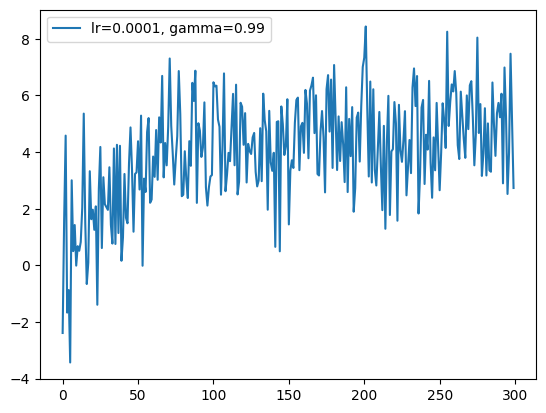

In [21]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()


Setup a mixed LLM vs Rules based AI adversary and compare performance

LLM related config, like which LLM to use

In [28]:
USE_OPENAI=False
LLAMA3_BASE_URL= os.environ.get('LLAMA3_BASE_URL', 'http://localhost:8000/v1')

In [29]:
prompt = GPT4Interfacer(debug=False, tools=False, base_url=LLAMA3_BASE_URL, api_key="token1234", variant="NousResearch/Meta-Llama-3.1-8B-Instruct", explain=False)

Setup interface for the adversarial moves

In [30]:
class CustomAgent:
    def __init__(self, llm_interface):
        self.llm_interface = llm_interface

    def action(self, observation, info):
        return self.llm_interface.select_action_for_state(observation, info)

    def __str__(self) -> str:
        return "Custom LLM Agent"

agent = CustomAgent(prompt)

We make an evaluation environment and a training environment. The evaluation environment is the same env config as the previous training run, while the training environment incorporates the LLM as the adversary. We do this to compare the training results.

In [31]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController

eval_env = make_env(game_setup_path)

def mix_controller(session, mix=0.8, **kwargs):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent)

env = make_env(game_setup_path, custom_agent=mix_controller)

In [ ]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_2 = {}
for lr in learning_rates:
  results_2[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary")
    results_2[lr][gamma] = reward_per_episode

In [ ]:
for item in results_2:
  for gamma in results_2[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results_2[item][gamma]}")

In [ ]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results_2[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Configure prompter for mistral

In [33]:
VARIANT = 'mistralai/Mistral-7B-Instruct-v0.3'
MISTRAL_URL = os.environ.get('MISTRAL_URL', "http://localhost:8000/v1")
prompt_mistral = GPT4Interfacer(debug=False, tools=False, base_url=MISTRAL_URL, api_key="token1234", variant=VARIANT, explain=False)

In [34]:
class CustomAgent:
    def __init__(self, llm_interface):
        self.llm_interface = llm_interface

    def action(self, observation, info):
        return self.llm_interface.select_action_for_state(observation, info)

    def __str__(self) -> str:
        return "Custom LLM Agent"

agent_mistral = CustomAgent(prompt_mistral)

In [35]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController
from llm_interface import GPT4Interfacer

eval_env = make_env(game_setup_path)

def mix_controller_mistral(session, mix=0.8, **kwargs):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent_mistral)

env = make_env(game_setup_path, custom_agent=mix_controller_mistral)

In [ ]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_4 = {}
for lr in learning_rates:
  results_4[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary_mistral")
    results_4[lr][gamma] = reward_per_episode

In [ ]:
for item in results_4:
  for gamma in results_4[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results_4[item][gamma]}")

# show the best reward found
print(f"Best reward: {max(results_4[0.001][0.99])}")

In [ ]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results_4[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Configure OpenAI GPT-4

In [20]:
VARIANT = 'gpt-4o-mini'
BACKUP_VARIANT = 'NousResearch/Meta-Llama-3.1-8B-Instruct'

In [24]:

prompt_gpt4 = GPT4Interfacer(debug=False, tools=True, api_key="OPENAI_TOKEN", variant=VARIANT, explain=False)
prompt_backup = GPT4Interfacer(debug=False, tools=False, base_url=LLAMA3_BASE_URL, api_key="token1234", variant=BACKUP_VARIANT)

class CustomAgentGPT4:
    """
    Custom agent that uses the GPT-4 model for action selection.
    Uses a backup LLM for movement and free action selection.
    """
    def __init__(self, llm_interface, backup_interface=None):
        self.llm_interface = llm_interface
        self.backup_interface = backup_interface
        self.invocation_count = 0
        self.backup_invocation_count = 0

    def action(self, observation, info):
        action, bonus_action, _ =  observation["turn_info"]
        if self.backup_interface is not None and action==0:
            self.backup_invocation_count += 1
            return self.backup_interface.select_action_for_state(observation, info)

        self.invocation_count += 1
        return self.llm_interface.select_action_for_state(observation, info)

    def __str__(self) -> str:
        return "Custom LLM Agent"

    def __repr__(self) -> str:
        return "Custom LLM Agent"

agent_gpt4 = CustomAgentGPT4(prompt_gpt4, backup_interface=prompt_backup)


In [25]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController

eval_env = make_env(game_setup_path)

def mix_controller_gpt4(session, mix=0.8, **kwargs):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent_gpt4)

env = make_env(game_setup_path, custom_agent=mix_controller_gpt4)

In [ ]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_5 = {}
for lr in learning_rates:
  results_5[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    results_5[lr][gamma] = []
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               reward_per_episode=results_5[lr][gamma],
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary_gpt4")
    results_5[lr][gamma] = reward_per_episode

In [ ]:
for item in results_5:
  for gamma in results_5[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results_5[item][gamma]}")

# show the best reward found
print(f"Best reward: {max(results_5[0.001][0.99])}")

In [ ]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results_5[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

In [ ]:
VARIANT = 'gpt-4o'
BACKUP_VARIANT = 'NousResearch/Meta-Llama-3.1-8B-Instruct'
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY', None)

In [ ]:
prompt_gpt4 = GPT4Interfacer(debug=False, tools=True, api_key=OPENAI_API_KEY, variant=VARIANT, explain=False)
agent_gpt4 = CustomAgentGPT4(prompt_gpt4, backup_interface=prompt_backup)

from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController

eval_env = make_env(game_setup_path)

def mix_controller_gpt4(session, mix=0.8, **kwargs):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent_gpt4)

env = make_env(game_setup_path, custom_agent=mix_controller_gpt4)

In [ ]:
seed = 1337
# # Create a grid of learning rates and gammas
# learning_rates = [0.001]
# gammas = [0.99]

# results_6 = {}
# reward_per_episode = []
# for lr in learning_rates:
#   results_6[lr] = {}
#   for gamma in gammas:
#     seed = seed + 1
#     results_6[lr][gamma] = []
#     reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
#                                reward_per_episode=results_6[lr][gamma],
#                                eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary_gpt4_2")
#     results_6[lr][gamma] = reward_per_episode

Summarize best Avg. Rewards obtained from each training method

In [ ]:
results = {}
results[0.001] = {}
results[0.001][0.99] = [-7.634523809523809, -3.7698412698412698, -2.4611111111111112, 0.12420634920634925, -4.1460317460317455, -3.848412698412699, -1.9047619047619049, 1.5638888888888889, -1.4793650793650794, 0.19523809523809518, -1.801984126984127, 2.0448412698412697, 0.030158730158729982, 0.8888888888888887, 1.3702380952380953, 3.7460317460317456, 1.925, -1.6642857142857141, 2.0055555555555555, 1.753968253968254, 1.8, 1.5722222222222222, 2.4007936507936507, 4.449999999999999, 3.3579365079365084, 1.650793650793651, 1.9138888888888885, 4.8388888888888895, 1.8265873015873018, 0.757936507936508, 2.0436507936507935, -0.9964285714285714, 1.2666666666666668, 3.8055555555555554, 3.211111111111111, 0.1599206349206352, 0.38888888888888873, 2.65, 2.2079365079365085, 0.7555555555555554, 5.116666666666667, 1.7682539682539684, 2.522222222222222, 3.7888888888888888, 4.283333333333333, 3.4333333333333336, 3.2999999999999994, 2.354761904761905, 0.5055555555555555, 0.041666666666666644, 3.0980158730158736, 4.307936507936508, 3.40952380952381, 2.3083333333333336, 1.9777777777777776, 2.0888888888888886, 2.8809523809523814, 0.9626984126984126, 2.7999999999999994, 5.114285714285714, 0.24246031746031732, 3.538492063492064, 3.6317460317460313, 3.8337301587301584, 3.584920634920635, 2.906746031746031, 4.142857142857142, 0.9460317460317461, 4.44404761904762, 3.226190476190476, 3.2, 3.3317460317460315, 3.271428571428571, 1.1944444444444442, 3.425396825396825, 2.7376984126984127, 5.161904761904761, 3.8416666666666663, 3.501587301587301, 1.734920634920635, 2.083333333333333, 3.7476190476190476, 3.2904761904761903, 5.750396825396825, 4.102777777777778, 2.8706349206349207, 2.6519841269841264, 3.9178571428571427, 1.575, 3.088095238095238, 4.911111111111111, 3.738888888888889, 3.4444444444444446, 5.966666666666666, 3.6869047619047617, 5.313888888888889, 5.48452380952381, 4.851984126984127, 2.298809523809524, 4.462301587301587]


In [ ]:
rewards_per_method = {}
for item in results:
  for gamma in results[item]:
    rewards_per_method["rules_based"] = np.max(results[item][gamma])
for item in results_2:
  for gamma in results_2[item]:
    rewards_per_method["llm_llama3"] = np.max(results_2[item][gamma])
for item in results_4:
    for gamma in results_4[item]:
        rewards_per_method["llm_mistral"] = np.max(results_4[item][gamma])
for item in results_5:
    for gamma in results_5[item]:
        rewards_per_method["llm_gpt4o"] = np.max(results_5[item][gamma])

# show a table of the best rewards from each method:

import pandas as pd
df = pd.DataFrame(rewards_per_method.items(), columns=["method", "rewards" ])
df


Perform some tests on the trained agent. Show a combat log from a fight against the rules based AI. Define a policy based on the Model.

In [ ]:
import os

MAX_STEPS = 500
NUM_EPISODES = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModelPolicy:
    def __init__(self, weights_file = 'model_best_dnd_egreedy.pt'):
        self.model = QNetwork(device=device)
        self.model.to(device)
        if not os.path.exists(weights_file):
            raise FileNotFoundError(f"Model file {weights_file} not found. Please run dnd_dqn.ipynb notebook to train an agent.")
        self.model.load_state_dict(torch.load(weights_file))

    def action(self, state, info):
        available_moves = info["available_moves"]
        values = torch.stack([self.model(state, move) for move in available_moves])
        for index, v in enumerate(values):
            print(f"{index}: {available_moves[index]} {v.item()}")

        chosen_index = torch.argmax(values).item()
        return available_moves[chosen_index]


In [ ]:

env = make_env(game_setup_path)

print("=========================================")
print("Battle between an RL agent vs a Rules based AI")
print("=========================================")
win_count = 0
loss_count = 0
for i in range(NUM_EPISODES):
    observation, info = env.reset()
    model = ModelPolicy()
    action = action = model.action(observation, info)

    print(f"selected action: {action}")
    terminal = False
    episode = 0

    while not terminal and episode < MAX_STEPS:
        episode += 1
        observation, reward, terminal, truncated, info = env.step(action)
        print(env.render())
        if not terminal and not truncated:
            episode_name_with_padding = str(episode).zfill(3)

            # display entity healths
            print(f"Turn {info['current_index']}\n")
            print(f"Reward: {reward}\n")
            print(f"health hero: {observation['health_pct']}\n")
            print(f"health enemy: {observation['health_enemy']}\n")
            print(env.render())
            
            action = model.action(observation, info)
            print(f"agent selected action: {action}")

        if terminal or truncated:
            print(f"Reward: {reward}")
            if reward > 0:
                win_count += 1
            else:
                loss_count += 1
            break
        
print(f"Win count: {win_count} Loss count: {loss_count} Win rate: {win_count/(win_count+loss_count)}")